In [97]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import sys
from torch.utils.data import Subset
from torchvision import transforms
import tqdm
import seaborn as sns
import pandas as pd

###
if '/home/jiaxuan/credible_learning/' not in sys.path:
    sys.path = ['/home/jiaxuan/credible_learning/'] + sys.path
from lib.data import Mimic2

In [9]:
d = Mimic2()

<AxesSubplot:>

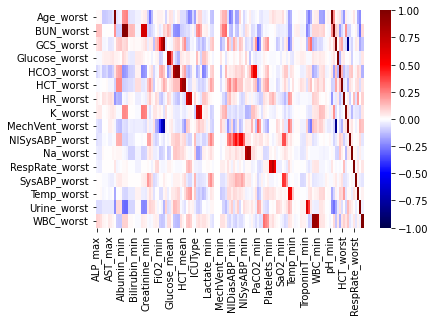

In [28]:
sns.heatmap(d.data.iloc[:, 2:].corr().iloc[-16:], cmap='seismic', vmin=-1, vmax=1)

In [24]:
d.data.iloc[:,2:].iloc[:,d.r.numpy().astype(bool)]

,Age_worst,BUN_worst,GCS_worst,Glucose_worst,HCO3_worst,HCT_worst,HR_worst,K_worst,MechVent_worst,NISysABP_worst,Na_worst,RespRate_worst,SysABP_worst,Temp_worst,Urine_worst,WBC_worst
0,54.0,13.0,15.0,205.000000,26.0,33.5,58.0,4.400000,12.0,157.000000,137.0,12.000000,115.134094,35.1,2470.0,11.2
1,76.0,16.0,3.0,105.000000,21.0,24.7,80.0,4.300000,49.0,122.469331,139.0,21.725615,66.000000,34.5,3474.0,7.4
2,44.0,3.0,5.0,119.000000,24.0,26.7,57.0,8.600000,49.0,150.000000,137.0,21.725615,115.134094,39.0,2910.0,3.7
3,68.0,23.0,14.0,106.000000,27.0,36.1,57.0,4.000000,12.0,102.000000,140.0,12.000000,115.134094,35.1,1400.0,8.8
4,88.0,45.0,15.0,113.000000,18.0,22.6,67.0,6.000000,12.0,156.000000,140.0,26.000000,115.134094,35.8,1196.0,3.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,70.0,14.0,3.0,121.000000,21.0,27.5,113.0,2.400000,49.0,122.469331,138.0,21.725615,88.000000,35.5,983.0,11.5
3996,25.0,3.0,15.0,65.000000,20.0,30.3,59.0,3.600000,12.0,150.000000,138.0,14.000000,115.134094,35.5,2350.0,4.7
3997,44.0,10.0,7.0,99.000000,23.0,37.9,111.0,4.000000,49.0,94.000000,140.0,21.725615,115.134094,37.1,2000.0,11.8
3998,37.0,98.0,6.0,125.000000,31.0,28.8,74.0,4.100000,49.0,122.469331,143.0,21.725615,203.000000,39.4,48.0,12.1


In [86]:
d.data.iloc[:, 2:].corr().iloc[:-16, -16:].max(1) > 0.8

ALP_max        False
ALP_mean       False
ALP_min        False
ALT_max        False
ALT_mean       False
               ...  
Weight_mean    False
Weight_min     False
pH_max         False
pH_mean        False
pH_min         False
Length: 115, dtype: bool

In [147]:
# List of S
threshold = 0.8
zs = d.data.iloc[:, 2:].corr().iloc[:-16, -16:].max(1) > threshold
zs = pd.DataFrame({'index':zs.index, 'values':zs.values})
zs = list(zs.loc[zs.values==True,'index'].values)
# print('s', len(zs), zs)

# List of C
zc = list(d.data.columns.values[-16:])
# print('c', zc)

# List of U (not C or S)
zu = [x for x in d.data.columns.values[2:] if x not in zc and x not in zs]
# print('u', len(zu), zu)

# Correlation(u, s)
# d.data.loc[:,zu+zs].corr().iloc[:-len(zs), -len(zs):].max(1)
sum(d.data.loc[:,zu+zs].corr().iloc[:-len(zs), -len(zs):].max(1) > 0.5) / len(zu) # % of u that is correlated with s

0.09090909090909091

In [110]:
d.data.iloc[:, 2:].corr().iloc[:-16, -16:].max(1)

ALP_max        0.118136
ALP_mean       0.118252
ALP_min        0.110337
ALT_max        0.057753
ALT_mean       0.053643
                 ...   
Weight_mean    0.123348
Weight_min     0.111330
pH_max         0.035385
pH_mean        0.025075
pH_min         0.041680
Length: 115, dtype: float64

In [81]:
sum(d.data.iloc[:, 2:].corr().iloc[:-16, -16:].max(1) > 0.8) # U correlation with C

16

In [64]:
c = d.xtrain_[:, d.r_==1]
x = d.xtrain_[:, [0]]
a = np.hstack([x, c])
corr = np.corrcoef(a.T)
corr.shape

(17, 17)

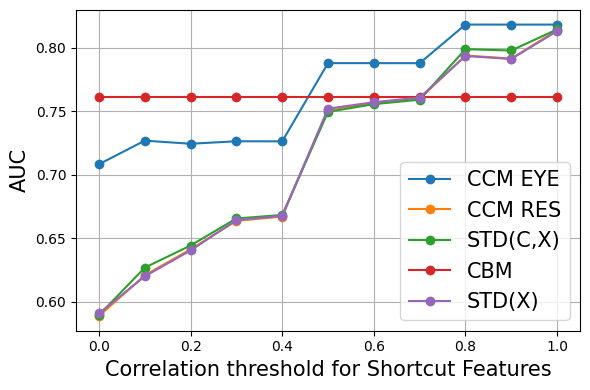

In [76]:
threshold = np.array([1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0])
removed_features = np.array([0, 10, 15, 24, 32, 38, 43, 49, 63, 80, 112])

# clean dataset performance
clean = { # the first is also the biased performance
    'CBM': [0.761307] * len(removed_features),
    'STD(X)': [0.813217, 0.791293, 0.793596, 0.760811, 0.757213, 0.752076, 0.667499, 0.664195, 0.640312, 0.619885, 0.590613],
    'STD(C,X)': [0.814570, 0.79796, 0.799001, 0.759155, 0.755658, 0.749571, 0.668264, 0.665523, 0.644196, 0.626728, 0.589327],
    'CCM RES': [0.813965, 0.791612, 0.794008, 0.759911, 0.756465, 0.751152, 0.667020, 0.663632, 0.641229, 0.620708, 0.588512],
    'CCM EYE': [0.818387, 0.818378, 0.818395, 0.787955, 0.787997, 0.787997, 0.726336, 0.726386, 0.724436, 0.726874, 0.708279]
}

fig, ax = plt.subplots(1,1,dpi=100) #dpi=300)

for key in ['CCM EYE', 'CCM RES', 'STD(C,X)', 'CBM', 'STD(X)']: #clean.keys():
    # plt.plot(removed_features / 115 * 100, clean[key], '-o', label=key)
    plt.plot(threshold, clean[key], '-o', label=key)

plt.legend(fontsize=15)
plt.ylabel('AUC', fontsize=15)
# plt.xlabel('Non-C Shortcut Features (%)', fontsize=15)
plt.xlabel('Correlation threshold for Shortcut Features', fontsize=15)
plt.grid()
plt.tight_layout()
plt.savefig('figures/physionet_shortcut.png')
plt.show()

In [31]:
d.data.shape

(4000, 133)

In [35]:
(d.r==0).sum()

tensor(115)

In [77]:
49/112

0.4375